### Titanic Survival Prediction Algorithms

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch

In [ ]:
# unload data

ytest = pd.read_csv("gender_submission.csv")
Xtest = pd.read_csv("test.csv")

train_data = pd.read_csv("train.csv")
Xtrain = train_data.drop(["Survived"], axis = 1)
ytrain = train_data[["Survived"]]

In [ ]:
# Logistic Regression Preprocessing

for X in [Xtrain, Xtest]:

  X.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis = 1, inplace = True)

  # replace missing float values with mean
  X["Age"], X["Fare"] = [X[col].fillna(np.mean(X[col])) for col in ["Age", "Fare"]]

  # replace missing ordinal values with median

  # replace missing binary values with mode

  X["Sex"] = np.where(X["Sex"] == "male", 1, 0)
  X["Embarked"] = np.where(X["Embarked"] == "S", 1, 0)

ytest = ytest.drop("PassengerId", axis = 1)

In [ ]:
ytest

,Survived
0,0
1,1
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [ ]:
# Convert dfs to float tensors

Xtrain, ytrain, Xtest, ytest = [torch.tensor(df.astype("float").values) for df in [Xtrain, ytrain, Xtest, ytest]]

In [ ]:
# define logistic regression model

class LogisticRegression(torch.nn.Module):

  def __init__(self, input_dim, output_dim, alpha = 0.01, momentum = 0.9):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)
    self.optim = torch.optim.SGD(self.linear.parameters(), lr = alpha, momentum = 0.9)
    self.lossFun = torch.nn.MSELoss()
    self.double()
    self.losses = []
  
  # return is simply the sigmoid of a linear model
  def __call__(self, X):
    return torch.round(self.forward(X))

  def forward(self, X):
    X = self.linear(X)
    X = torch.sigmoid(X)
    return X

  def train(self, X_train, y_train, n_epochs = 1000, verbose = True):
    
    for epoch in range(n_epochs):

      # zero gradients
      self.optim.zero_grad()

      # make predictions
      y_pred = self.forward(X_train)

      # calculate loss
      loss = self.lossFun(y_pred, y_train)
      self.losses.append(loss)

      # find gradients
      loss.backward()

      # change weights
      self.optim.step()

      if epoch % 1000 == 0 and verbose:
        print(loss)

  def test(self, X, y):

      # make predictions
      y_pred = model(X)

      # find loss
      accuracy = 1 - torch.sum(torch.abs(torch.round(y_pred) - torch.round(y))) / len(y)

      return accuracy

  def getLosses(self):
      return self.losses

In [ ]:
# Create model and test

model = LogisticRegression(Xtrain.shape[1], 1)
model.train(Xtrain, ytrain, n_epochs = 20000, verbose = False)

train_acc = model.test(Xtrain, ytrain)
test_acc = model.test(Xtest, ytest)

print(f"""Train Accuracy: \033[1m{train_acc}\033[0m\n
Test Accuracy: \033[1m{test_acc}\033[0m""")

Train Accuracy: 0.8069584736251403

Test Accuracy: 0.9401913875598086


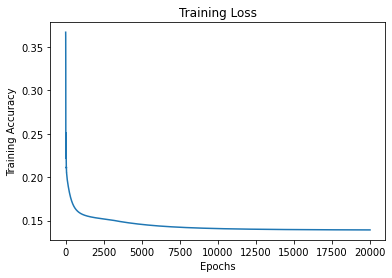

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.plot(model.getLosses())